# HandFlow Model Evaluation Dashboard

Evaluate model metrics and visualize misclassified sequences.

In [18]:
import sys
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML

# Add src to path
sys.path.insert(0, str(Path.cwd().parent / "src"))

from handflow.utils.config import load_config
from handflow.data.loader import load_processed_data
from handflow.evaluation import ModelEvaluator, FeatureVisualizer

In [19]:
# Configuration
HAND = 'right' # or 'left'
CONFIG_PATH = '../config/config.yaml'

# Locate Model and Data
MODEL_PATH = f'../models/hand_action.keras'
VAL_PATH = f'../data/processed/{HAND}_val.npz'
TRAIN_PATH = f'../data/processed/{HAND}_train.npz'

# Check existence
if not os.path.exists(MODEL_PATH):
    print(f"Error: Model not found at {MODEL_PATH}")

config = load_config(CONFIG_PATH)
print(f"Loading model from {MODEL_PATH}...")

Loading model from ../models/hand_action.keras...


In [20]:
# Load Data & Model
try:
    # Load Validation
    X_val, y_val, actions, paths_val = load_processed_data(VAL_PATH, include_paths=True)

    # Load Training (Optional)
    if os.path.exists(TRAIN_PATH):
        X_train, y_train, _ = load_processed_data(TRAIN_PATH)
        print(f"Loaded Training Samples: {len(X_train)}")
    else:
        X_train, y_train = None, None
        print("Training data not found.")

    evaluator = ModelEvaluator(MODEL_PATH, actions)
    print("✅ Model and Data loaded successfully.")
    print(f"Validation Samples: {len(X_val)}")
except Exception as e:
    print(f"Error loading: {e}")

Loaded Training Samples: 4167
✅ Model and Data loaded successfully.
Validation Samples: 736


/Users/huynhhuy/Documents/HandKey/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:797: UserWarning:

Skipping variable loading for optimizer 'rmsprop', because it has 32 variables whereas the saved optimizer has 62 variables. 



In [21]:
# Evaluate Training Data
if X_train is not None:
   print("--- Training Data Performance ---")
   train_metrics = evaluator.evaluate(X_train, y_train)
   print(f"Train Accuracy: {train_metrics['accuracy']:.2%}")
   print(f"Train F1: {train_metrics['f1']:.2f}")
else:
   print("Skipping training evaluation.")

--- Training Data Performance ---
Train Accuracy: 99.28%
Train F1: 0.99


In [22]:
# Normalize Validation Performance
print("\n--- Validation Data Performance ---")
metrics = evaluator.evaluate(X_val, y_val)

print(f"Accuracy: {metrics['accuracy']:.2%}")
print(f"F1 Score: {metrics['f1']:.2f}")
print("\nClassification Report:")
display(pd.DataFrame(metrics['report']).transpose())


--- Validation Data Performance ---
Accuracy: 99.46%
F1 Score: 0.99

Classification Report:


,precision,recall,f1-score,support
none,1.000000,0.995516,0.997753,223.000000
horizontal_swipe,1.000000,1.000000,1.000000,40.000000
swipeup,1.000000,1.000000,1.000000,15.000000
swipedown,0.967742,1.000000,0.983607,30.000000
thumb_left,1.000000,1.000000,1.000000,23.000000
thumb_right,1.000000,1.000000,1.000000,22.000000
pointyclick,1.000000,1.000000,1.000000,15.000000
middleclick,1.000000,1.000000,1.000000,15.000000
touch_hover,1.000000,0.989362,0.994652,94.000000
touch_hold,0.966292,1.000000,0.982857,86.000000


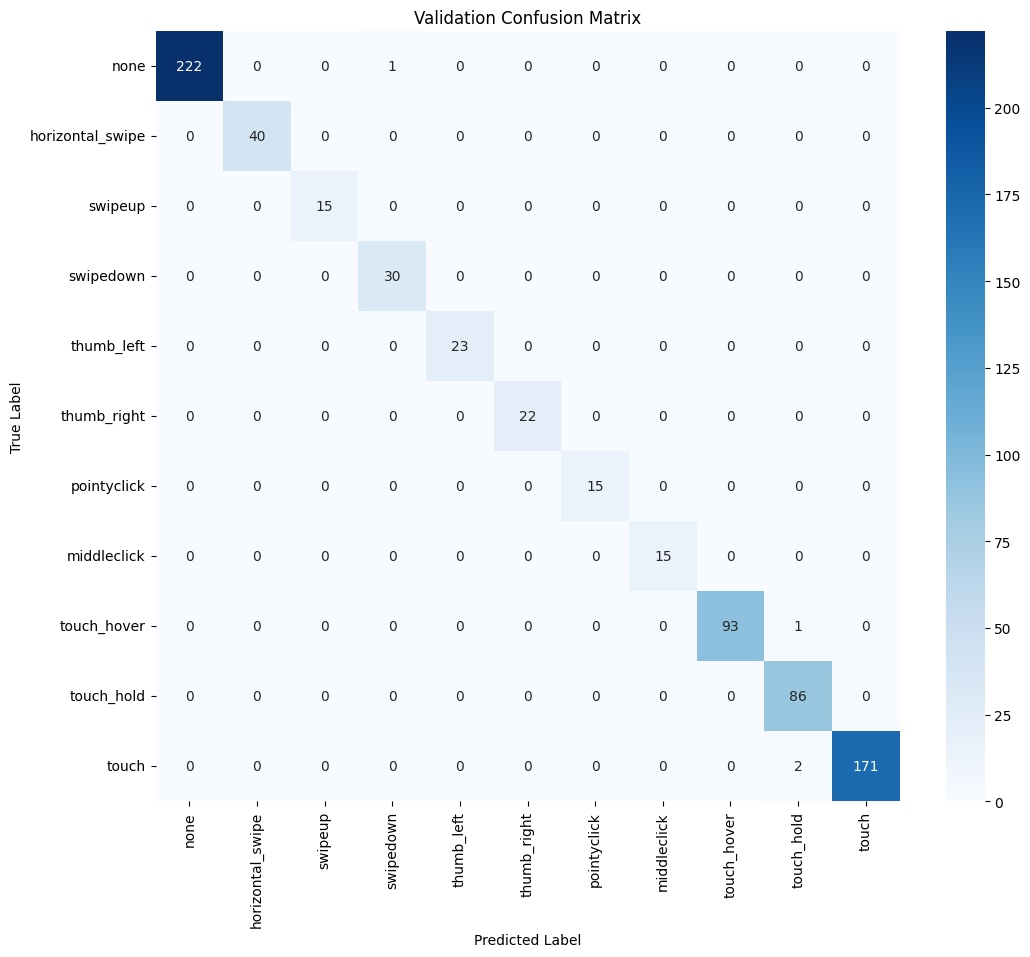

In [23]:
# Confusion Matrix
plt.figure(figsize=(12, 10))
sns.heatmap(metrics['confusion_matrix'], annot=True, fmt='d', 
            xticklabels=actions, yticklabels=actions, cmap='Blues')
plt.title('Validation Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [24]:
# Misclassified Samples Analysis
misclassified = evaluator.get_misclassified_samples(X_val, y_val, paths_val)
print(f"Found {len(misclassified)} misclassified samples.")
print(misclassified)

# Show summary of first few failures
summary_df = pd.DataFrame([{k:v for k,v in m.items() if k != 'data'} for m in misclassified])
if not summary_df.empty:
    display(summary_df)
else:
    print("No misclassified samples!")

Found 4 misclassified samples.
[{'index': 22, 'true_label': 'touch_hover', 'pred_label': 'touch_hold', 'true_idx': 8, 'pred_idx': 9, 'confidence': 0.6084581, 'data': array([[0.        , 0.        , 0.        , ..., 2.13206628, 2.27670101,
        2.29756739],
       [0.        , 0.        , 0.        , ..., 2.14077374, 2.29067085,
        2.33615847],
       [0.        , 0.        , 0.        , ..., 2.22132374, 2.3149273 ,
        2.31432742],
       ...,
       [0.        , 0.        , 0.        , ..., 1.98174914, 2.06252622,
        2.19308419],
       [0.        , 0.        , 0.        , ..., 2.03365515, 2.13987824,
        2.18678468],
       [0.        , 0.        , 0.        , ..., 2.09368428, 2.14951293,
        2.19920181]]), 'path': 'right_mp_data/touch_hover/157'}, {'index': 27, 'true_label': 'none', 'pred_label': 'swipedown', 'true_idx': 0, 'pred_idx': 3, 'confidence': 0.8486765, 'data': array([[0.        , 0.        , 0.        , ..., 2.69813703, 2.70967629,
        2.61135

,index,true_label,pred_label,true_idx,pred_idx,confidence,path
0,22,touch_hover,touch_hold,8,9,0.608458,right_mp_data/touch_hover/157
1,27,none,swipedown,0,3,0.848677,right_mp_data/none/233
2,127,touch,touch_hold,10,9,0.623039,right_mp_data/touch/1151
3,409,touch,touch_hold,10,9,0.517237,right_mp_data/touch/16


## Visualization of Misclassified Sequences
Iterate through the `misclassified` list to view animation and feature graphs.

Analyzing Misclassified Sample #0 (Dataset Index: 22)
True: touch_hover | Predicted: touch_hold | Confidence: 0.61
Raw data path: right_mp_data/touch_hover/157
Generating Animation...


Generating Feature Plot...


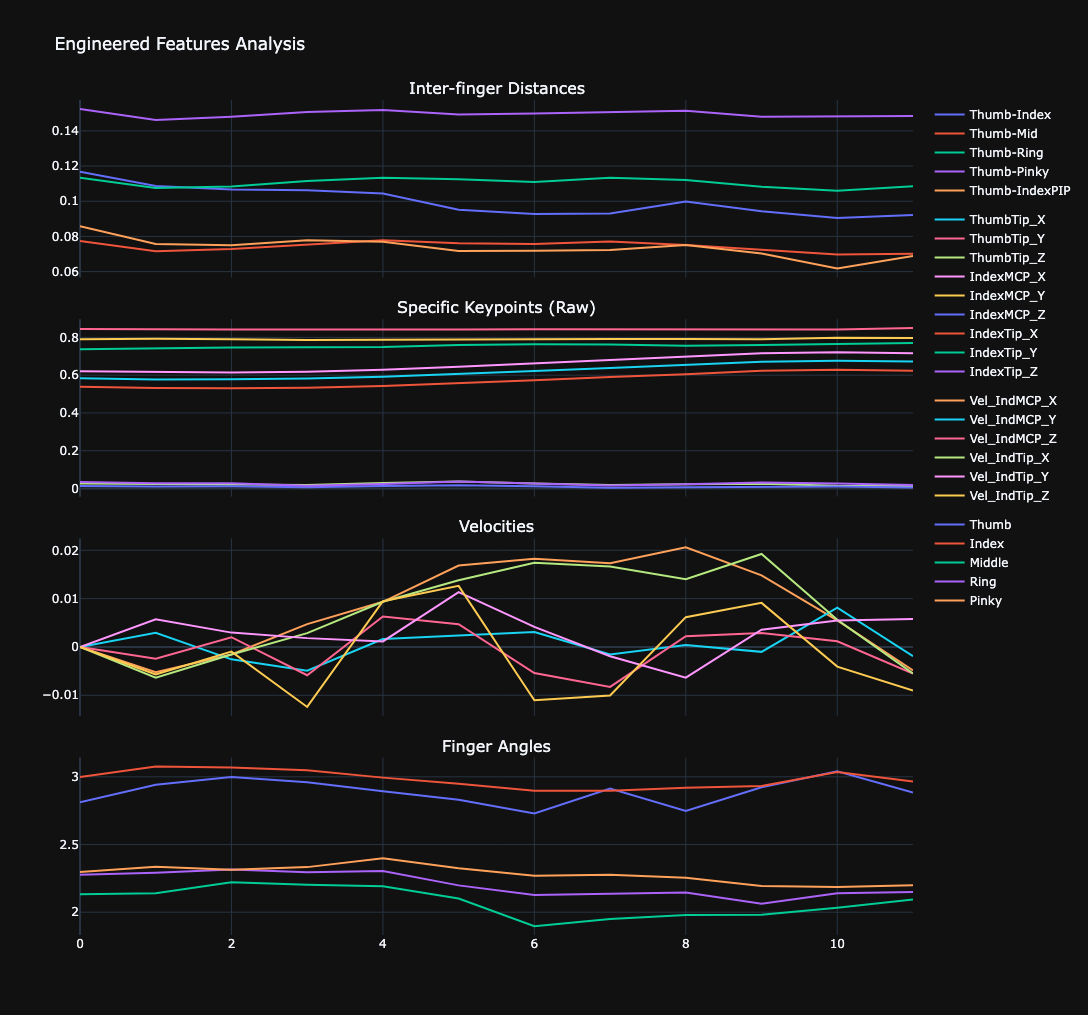

Analyzing Misclassified Sample #1 (Dataset Index: 27)
True: none | Predicted: swipedown | Confidence: 0.85
Raw data path: right_mp_data/none/233
Generating Animation...


Generating Feature Plot...


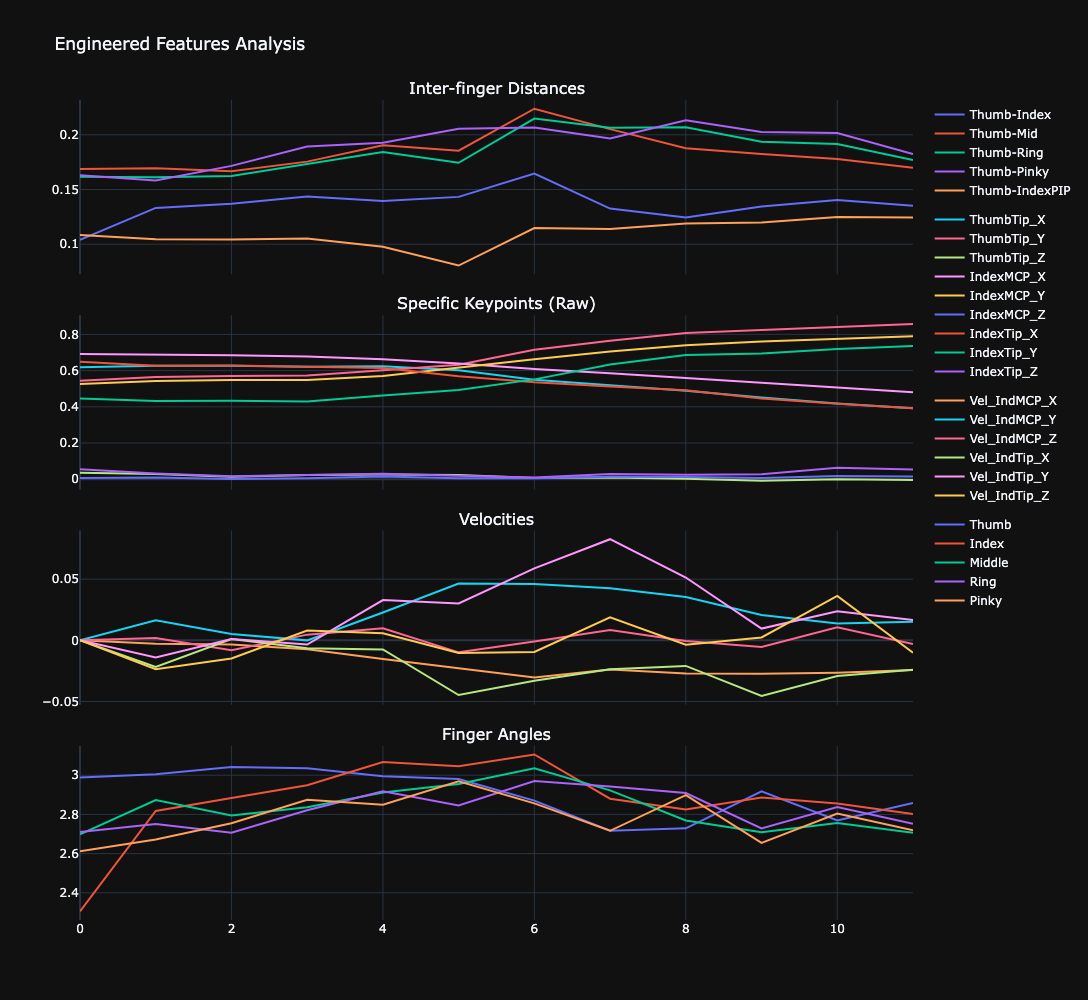

Analyzing Misclassified Sample #2 (Dataset Index: 127)
True: touch | Predicted: touch_hold | Confidence: 0.62
Raw data path: right_mp_data/touch/1151
Generating Animation...


Generating Feature Plot...


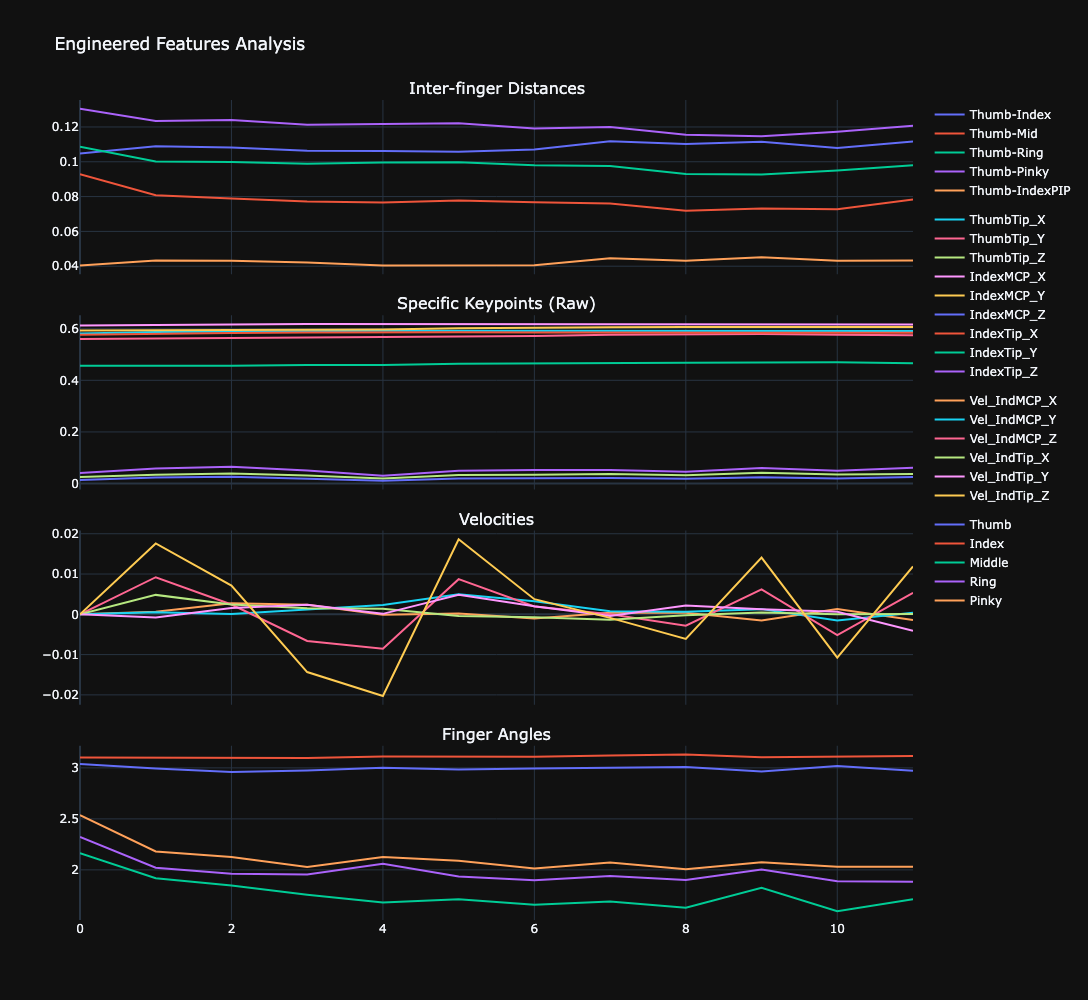

Analyzing Misclassified Sample #3 (Dataset Index: 409)
True: touch | Predicted: touch_hold | Confidence: 0.52
Raw data path: right_mp_data/touch/16
Generating Animation...


Generating Feature Plot...


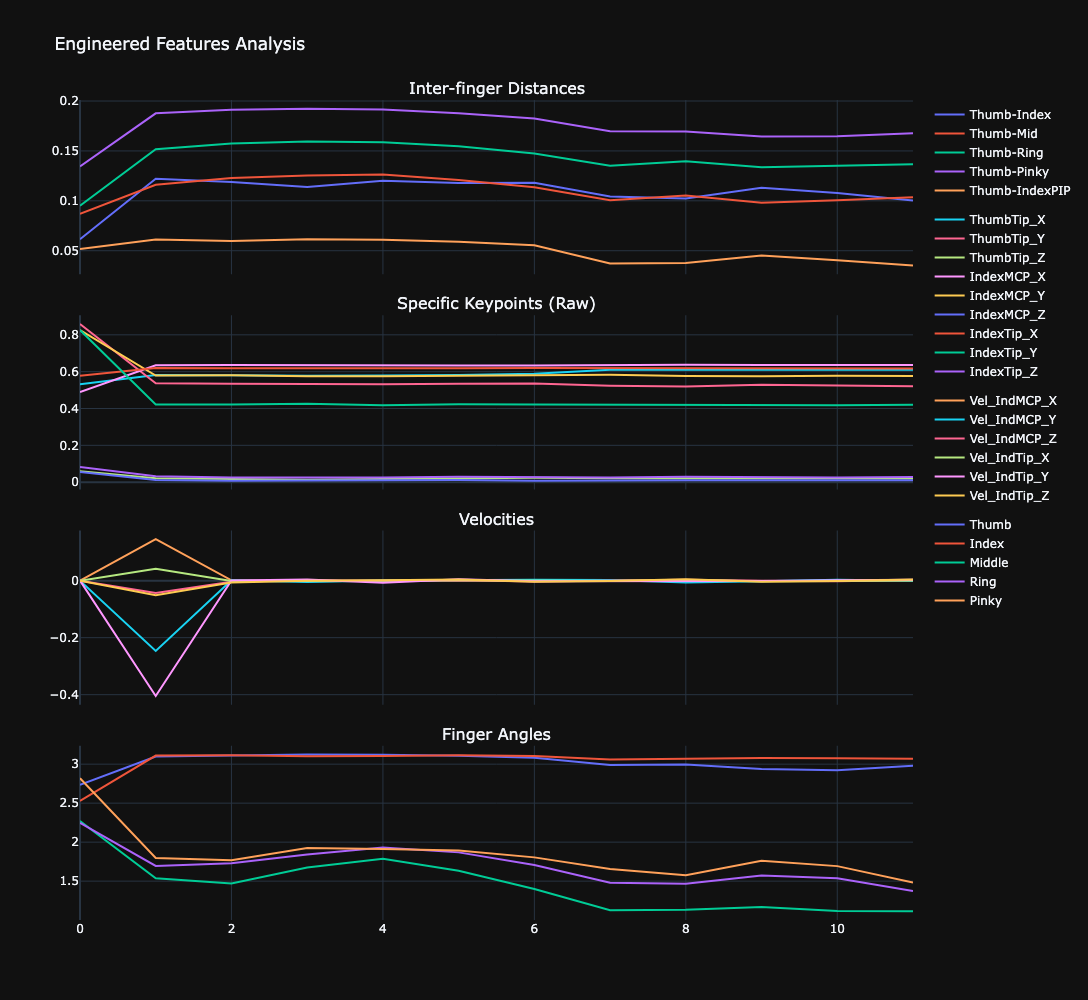

In [25]:
def analyze_sample(sample_idx_in_list):
    if not misclassified:
        print("No errors to analyze.")
        return

    if sample_idx_in_list >= len(misclassified):
        print(f"Index {sample_idx_in_list} out of range (Total: {len(misclassified)})")
        return
        
    sample = misclassified[sample_idx_in_list]
    print(f"Analyzing Misclassified Sample #{sample_idx_in_list} (Dataset Index: {sample['index']})")
    print(f"True: {sample['true_label']} | Predicted: {sample['pred_label']} | Confidence: {sample['confidence']:.2f}")
    print(f"Raw data path: {sample['path']}")
    
    # 1. Animation (Matplotlib -> HTML JS)
    print("Generating Animation...")
    anim = FeatureVisualizer.create_gesture_animation(
        sample['data'], 
        title=f"True: {sample['true_label']} | Pred: {sample['pred_label']}"
    )
    display(HTML(anim.to_jshtml()))
    
    # 2. Features (Plotly Interactive)
    print("Generating Feature Plot...")
    fig = FeatureVisualizer.create_feature_plot(sample['data'])
    fig.show()

# Change index to view different failures (0, 1, 2, ...)
for idx, sample in enumerate(misclassified):
    analyze_sample(idx)